# DQN

# 環境生成

In [1]:
import gym
import random
import numpy as np
import torch
from torch import nn
from torch  import optim
import torch.nn.functional as F
from gym import wrappers
import matplotlib.pyplot as plt
env = gym.make('MountainCar-v0')

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 環境をリセット

In [4]:
observation  = env.reset()
print(observation)
# 現在の位置，速度

[-0.5471447  0.       ]


In [5]:
print(env.observation_space.high)
print(env.observation_space.low)
#観測データの最大値
#観測データの最小値

[0.6  0.07]
[-1.2  -0.07]


# エージェントを動かす
0: 左へおす\
1: 何もしない\
2: 右へおす
```
action = 0~2
env.step(action)
```

# DQN
行動価値関数Qをニューラルネットワーク化して，学習\
R(s,a)+γmaxa′∈A(s′)Q(s′,a′)\
を教師データと考えてθを更新する

In [6]:
#各ステップでの経験をnamedtupleに変換
from collections import namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [7]:
# 経験を保存するメモリクラス
#Replay Memory・・・そのステップでの経験を保存
class ReplayMemory:
    def __init__(self, CAPACITY):
        self.capacity = CAPACITY #メモリの最大長
        self.memory = []#経験
        self.index = 0# 保存するindexを示す変数
    
    def push(self, state, action, state_next, reward):
        '''transition = (state, action, state_next, reward)をメモリに保存'''
        if len(self.memory) < self.capacity:
            self.memory.append(None)#メモリが一杯出ない時には足す
            self.memory[self.index] = Transition(state, action, state_next, reward)
            self.index = (self.index + 1) % self.capacity #保存するindexを１つずらす　最大を超えないように
            
    def sample(self, batch_size):
        '''batch_size分だけ，ランダムに保存内容を取り出す'''
        return random.sample(self.memory, batch_size)

    def __len__(self): #リストや辞書型利用時に使う特殊メソッド
        '''現在のmemoryの長さを返す'''
        return len(self.memory)

In [8]:
GAMMA = 0.99 #時間割引率
BATCH_SIZE = 32
CAPACITY = 10000
# DQNの処理
class DQN_Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions #左へおす，何もしない，右へおすの3つ
        self.num_states = num_states
        self.memory = ReplayMemory(CAPACITY)
        
        #ニューラルネットワーク
        self.model = nn.Sequential()
        self.model.add_module('fc1', nn.Linear(num_states, 32))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('fc2', nn.Linear(32, 32))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('fc3', nn.Linear(32, num_actions))
        print(self.model)
        self.optimizer = optim.Adam(self.model.parameters())
        #learning rateはsensitiveなので，とりあえずdefault1e-3
        
    def replay(self):
        '''Experience Replayでネットワークのパラメータを学習'''
        #メモリサイズの確認
        if len(self.memory) < BATCH_SIZE:
            return
        
        #ミニバッチの作成
        transitions = self.memory.sample(BATCH_SIZE)
        #TransitionsxBATCH_SIZE->各要素xBATCH_SIZEに分解
        batch = Transition(*zip(*transitions))
        #各要素ごとに結合してバッチにする
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        #予測のQ(s_t,a_t)を求める
        self.model.eval()
        state_action_values = self.model(state_batch).gather(1, action_batch) #actionの最大の要素と同じindexのstateの要素を取り出す
        #max(Q(s_t+1,a))の値を求める
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None, batch.next_state))) #次の状態があるかチェック
        next_state_values = torch.zeros(BATCH_SIZE)
        #次の状態があるindexの最大のQ値を求める
        next_state_values[non_final_mask] = self.model(non_final_next_states).max(1)[0].detach()
        #正解のQ(s_t,a_t)を求める
        expected_state_action_values = reward_batch + GAMMA * next_state_values
        
        #パラメータの更新
        self.model.train()
        #lossの計算
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        #更新
        self.optimizer.zero_grad()#勾配リセット
        loss.backward()
        self.optimizer.step()

    def decide_action(self, state, episode):
        '''現在の状態に応じて，行動を決定する'''
        #ε-greedy法で徐々に最適行動のみを採用する
        epsilon = 0.005 #0.5 * (1 / (episode + 1))
        if epsilon <= np.random.uniform(0,1): #99.5%の確率で最大の行動価値の行動を選択
            self.model.eval()
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1,1) #出力の最大値のindexを取り出し，1x1に変換
        else: #0.5%の確率で行動をrandomchoice
            #行動0,1,2をランダムに返す
            action = torch.LongTensor([[random.randrange(self.num_actions)]])
        return action

In [9]:
# Agent
class Agent:
    def __init__(self, num_states, num_actions):
        self.brain = DQN_Brain(num_states, num_actions)
    
    def update_q_function(self):
        '''Q関数を更新する'''
        self.brain.replay()
    
    def get_action(self, state, episode):
        '''行動を決定する'''
        action = self.brain.decide_action(state, episode)
        return action
    
    def memorize(self, state, action, state_next, reward):
        '''memoryオブジェクトにstate, action, state_next, rewardの内容を保存'''
        self.brain.memory.push(state, action, state_next, reward)

In [10]:
MAX_STEPS = 200 #１試行のステップ数
NUM_EPISODES = 10000 #試行回数

In [11]:
#Mountain Carを実行する環境のクラス
class Environment:
    def __init__(self):
        self.env = gym.make('MountainCar-v0')
        self.env = wrappers.Monitor(self.env, './gym-results/DQN', force=True) #動画保存
        self.num_states = self.env.observation_space.shape[0]
        self.num_actions = self.env.action_space.n
        self.agent = Agent(self.num_states, self.num_actions)
        self.rewards = []
        self.best_step = MAX_STEPS-1#頂上に到達した最小のステップ数を保存
    
    def run(self):
        '''実行'''
        episode_10_list = np.zeros(10) #10試行分の成功step数を格納し，平均step数を出力に利用
        complete_episodes = 0
        episode_final = False # 最後の試行フラグ
        observation = self.env.reset() #環境の初期化
        
        for episode in range(NUM_EPISODES):
            observation = self.env.reset() #環境の初期化
            state = observation
            state = torch.from_numpy(state).type(torch.FloatTensor)
            state = torch.unsqueeze(state, 0) #size4 ->1x4に変換
            total_reward = 0
            
            for step in range(MAX_STEPS): #1episodeのループ
                action = self.agent.get_action(state, episode)
                # a_tの実行後のs_{t+1}とdoneフラグを求める
                observation_next, reward, done, _ = self.env.step(action.item())
                #infoはない, actionはTensorなので値を取り出すitem(), rewardはMountainCarではステップごとに固定で-1

                #頂上に到達したら次状態はないのでNoneにし，episode終了
                if done:
                    state_next = None
                    if step < self.best_step:
                        self.best_step = step
                        # これまでの最小ステップで頂上に到達したら，reward1.0
                        reward = 1.0
                    elif step < MAX_STEPS-1:
                        # それ以外で頂上に到達した場合，reward0
                        reward = 0.0
# →失敗： 最小ステップ以外で頂上に到達したときの報酬を0.5とした
#報酬のclipping:報酬を-1,0,1で固定することで，問題によらず，同じハイパーパラメータで適用可能になる
#→改善: 最小のときのみ，報酬1.0とし，それ以外は-1とする．
                else:
                    state_next = torch.from_numpy(observation_next).type(torch.FloatTensor)
                    state_next = torch.unsqueeze(state_next, 0) #size2->1x2に変換
                
                #報酬を与える
                total_reward += reward
                reward = torch.FloatTensor([reward])
                
                #メモリに経験を追加
                self.agent.memorize(state, action, state_next, reward)
                
                #Experience ReplayでQ関数を更新
                self.agent.update_q_function()
                
                #観測の更新
                state = state_next
                
                if done:
                    if episode%100 == 0:
                        print('episide: {}, total_reward: {}'.format(episode, total_reward))
                    self.rewards.append(total_reward)
                    #頂上に到達したので，1episode終了
                    break

In [12]:
mountaincar_env = Environment()
mountaincar_env.run()

Sequential(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)
episide: 0, total_reward: -200.0
episide: 100, total_reward: -200.0
episide: 200, total_reward: -200.0
episide: 300, total_reward: -200.0
episide: 400, total_reward: -177.0
episide: 500, total_reward: -200.0
episide: 600, total_reward: -200.0
episide: 700, total_reward: -200.0
episide: 800, total_reward: -200.0
episide: 900, total_reward: -200.0
episide: 1000, total_reward: -167.0
episide: 1100, total_reward: -200.0
episide: 1200, total_reward: -200.0
episide: 1300, total_reward: -200.0
episide: 1400, total_reward: -200.0
episide: 1500, total_reward: -196.0
episide: 1600, total_reward: -200.0
episide: 1700, total_reward: -200.0
episide: 1800, total_reward: -120.0
episide: 1900, total_reward: -200.0
episide: 2000, total_reward: -200.0
episide: 2100, total_reward:

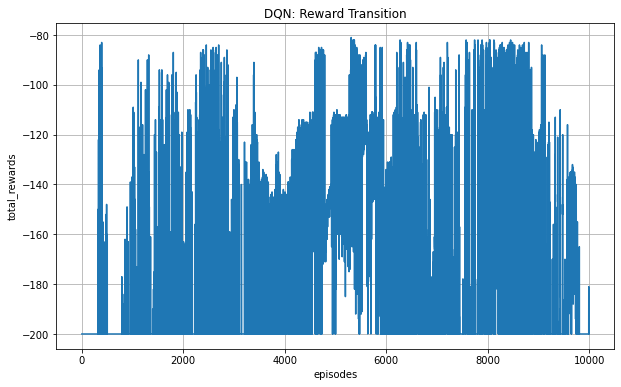

In [15]:
plt.figure(figsize=(10,6))
plt.title('DQN: Reward Transition')
x = list(range(0, NUM_EPISODES))
plt.plot(x, mountaincar_env.rewards)
plt.ylabel('total_rewards')
plt.xlabel('episodes')
plt.grid()
plt.savefig('./fig/DQN/DQN_RT.png')
plt.show()